In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import spatial
import itertools
import heapq

In [20]:
# https://digitology.tech/docs/python_3/library/heapq.html
class PriorityQueue:
    def __init__(self):
        self.queue = []
        self.data = {}
        self.position = itertools.count()

    def insert(self, key, priority):
        if key in self.data:
            self.remove(key)
        pos = next(self.position)
        entry = [priority, pos, key]
        self.data[key] = entry
        heapq.heappush(self.queue, entry)

    def remove(self, key):
        if key not in self.data:
            raise KeyError(f"Key '{key}' not found in priority queue")
        entry = self.data.pop(key)
        entry[-1] = None

    def decrease(self, key, priority):
        self.remove(key)
        self.insert(key, priority)

    def pop(self):
        while self.queue:
            priority, id, key = heapq.heappop(self.queue)
            if key is not None:
                del self.data[key]
                return key
        if not self.data:
            # print("no data")
            return None

In [35]:
class MYOPTICS(object):
    def __init__(self, points, epsilon = np.inf, minPts = 30):
        self.SetOfObjects = points
        n = self.SetOfObjects.shape[0]
        self.processed  = np.array([False] * n)
        self.reachability_distances = np.array([np.inf] * n)
        self.core_distances = np.array([np.inf] * n)
        self.epsilon = epsilon
        self.minPts = minPts
        self.ordered_points = []
        self.order_seeds = PriorityQueue()
        self.KDtree = spatial.cKDTree(self.SetOfObjects)
        self.labels = np.array([-1] * n)

    def optics(self):
        data = self.SetOfObjects
        for i in range(len(data)):
            point = data[i]
            if not self.processed[i]:
                self.ExpandClusterOrder(point, i)

    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.cKDTree.query.html
    def setCoreDistance(self, point, neighboursIdx):
        if len(neighboursIdx) >= self.minPts:
            distances, _ = self.KDtree.query(x=point, k=[self.minPts-1])
            return distances

    def ExpandClusterOrder(self, point, pointIdx):
        # https://stackoverflow.com/questions/32424604/find-all-nearest-neighbors-within-a-specific-distance
        neighboursIdx = self.KDtree.query_ball_point(point, self.epsilon)
        self.processed[pointIdx] = True
        self.reachability_distances[pointIdx] = np.inf
        self.core_distances[pointIdx] = self.setCoreDistance(point, neighboursIdx)
        self.ordered_points.append(pointIdx)
        if not np.isposinf(self.core_distances[pointIdx]):
            self.OrderSeedsUpdate(neighboursIdx, point, pointIdx)
        while True:
            currentPointIdx = self.order_seeds.pop()
            if not currentPointIdx:
                break
            currentPoint = self.SetOfObjects[currentPointIdx]
            currentPointNeighboursIdx = self.KDtree.query_ball_point(currentPoint, self.epsilon)
            self.processed[currentPointIdx] = True
            self.core_distances[currentPointIdx] = self.setCoreDistance(currentPoint, currentPointNeighboursIdx)
            self.ordered_points.append(currentPointIdx)
            if not np.isposinf(self.core_distances[currentPointIdx]):
                self.OrderSeedsUpdate(currentPointNeighboursIdx, currentPoint, currentPointIdx)


    def OrderSeedsUpdate(self, neighboursIdx, CenterObject, CenterObjectIdx):
        c_dist = self.core_distances[CenterObjectIdx]
        for i in range(len(neighboursIdx)):
            neighbour_idx = neighboursIdx[i]
            neighbour = self.SetOfObjects[neighbour_idx]
            if not self.processed[neighbour_idx]:
                new_r_dist = max(c_dist, np.linalg.norm(neighbour - CenterObject))
                if np.isposinf(self.reachability_distances[neighbour_idx]):
                    self.reachability_distances[neighbour_idx] = new_r_dist
                    self.order_seeds.insert(neighbour_idx, priority=new_r_dist)
                elif new_r_dist < self.reachability_distances[neighbour_idx]:
                    self.reachability_distances[neighbour_idx] = new_r_dist
                    self.order_seeds.decrease(neighbour_idx, priority=new_r_dist)


    def ExtractDBSCANClustering(self, new_eps):
        clusterID = 0
        for point in self.ordered_points:
            r_dist = self.reachability_distances[point]
            c_dist = self.core_distances[point]
            if r_dist > new_eps:
                if c_dist <= new_eps:
                    clusterID += 1
                    self.labels[point] = clusterID
                else:
                    self.labels[point] = -1
            else:
                self.labels[point] = clusterID
        return self.labels


    def draw_reachability_plot(self):
        reachability_distances = [self.reachability_distances[index] for index in self.ordered_points]
        fig = plt.figure()
        plt.plot(range(len(reachability_distances)), reachability_distances)
        plt.title("Reachability plot")
        plt.xlabel('Ordered Points')
        plt.ylabel('Reachability Distances')
        plt.show()

    def plot_clusters(self):
        fig = plt.figure()
        for i in range(-1, len(set(self.labels))):
            subCluster = self.SetOfObjects[np.where(self.labels == i)]
            plt.scatter(subCluster[:, 0], subCluster[:, 1], s=10)
        plt.title("Clusters")
        plt.xlabel("X")
        plt.ylabel("Y")
        plt.show()


## [Dataset](https://www.kaggle.com/datasets/samuelcortinhas/2d-clustering-data?select=data.csv)

In [68]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

In [69]:
df = pd.read_csv('data.csv')
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)

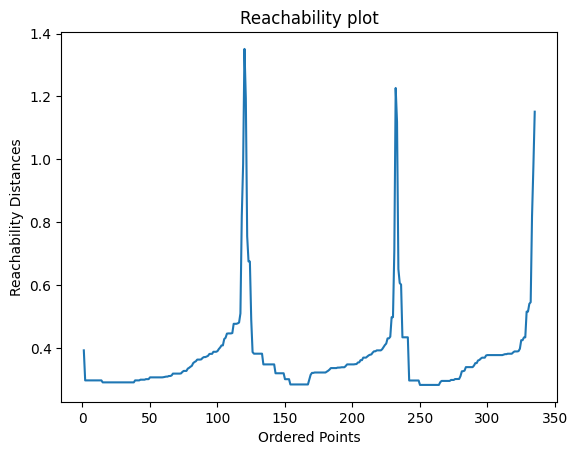

In [76]:
optics = MYOPTICS(df_scaled, epsilon = np.inf, minPts = 25)
optics.optics()
optics.draw_reachability_plot()

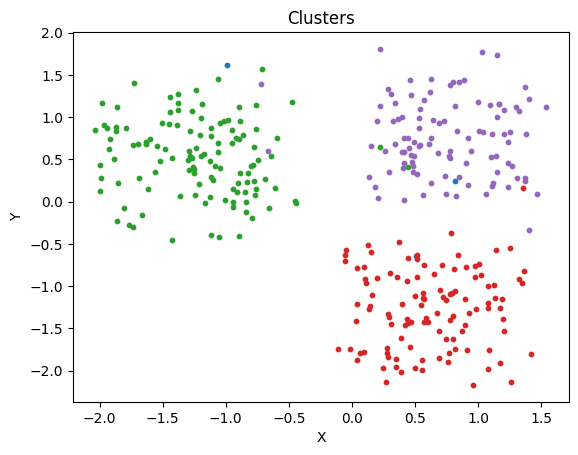

In [77]:
clusters = optics.ExtractDBSCANClustering(1)
optics.plot_clusters()

## Test

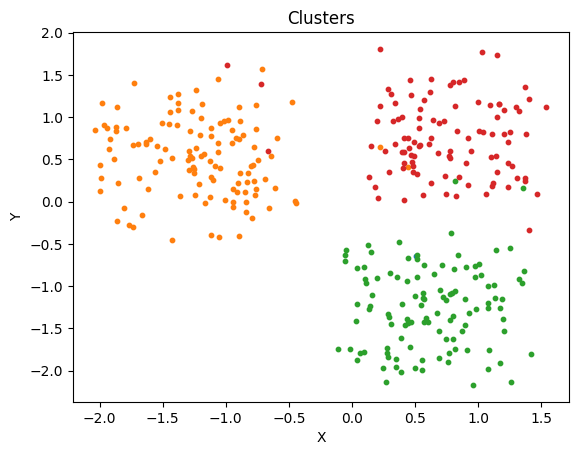

In [74]:
from sklearn.cluster import OPTICS
def plot_clusters(data, labels):
    fig = plt.figure()
    for i in range(-1, len(set(labels))):
        subCluster = data[np.where(labels == i)]
        plt.scatter(subCluster[:, 0], subCluster[:, 1], s=10)
    plt.title("Clusters")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.show()
clustering = OPTICS(min_samples=25).fit(df_scaled)
plot_clusters(df_scaled,clustering.labels_)